In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

# # use notebook path to find repo root, path to repo parent directory, and airflow dags repo
# # note that the two repos must by subdirs in some common parent for this to work
# nb_path = Path(os.path.abspath(""))
# emp_retention_repo_path = nb_path.parent
# all_repos_parent_path = emp_retention_repo_path.parent
# # append airflow-dags projs path and emp_retention repo path to python path
# sys.path.append(str(emp_retention_repo_path))


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# Variance caused by Heterogenous, small Sampling 
**NOT A BIAS ISSUE**
- Originally thought this was non exchangeability "bias" 
    - def: the untreated potential outcomes differ between the treatment group and the control group, this indicates a violation of randomization or exchangeability (sampling)
- but actually the expected value of the estimand is UNBIASED
- really a variance issue (see we get bimodal distribution of effects with this 
- we were able to easily fix it with variance reduction techniques (cuped, stratified sampling)
- so it's not a causal problem
    - these typically have to do with 

## Dataset similar to Kinetics jump adoption

Tomorrow
- write about kinetic dset
- show that sampling actually didn't fix it eventhough it is tempting (maybe stratefied would be but again just shows why we do power analysis)
- comment on power analysis - we could see how little of an effect we could observe with 80% power using cuped and how little using the random (curves -- power vs effect size)
- see tasks doc
- maybe tbr

,data,pareto
49,14.455313,45.81
37,15.630378,30.99
9,15.987628,27.68
22,16.934503,20.76
1,17.110321,19.71


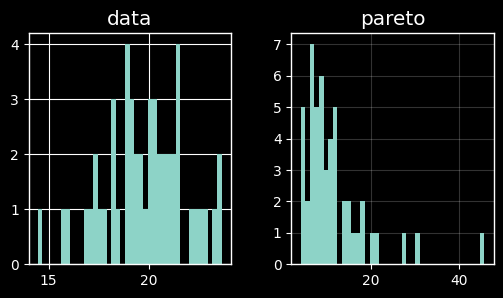

In [76]:
# data = np.random.normal(20,2,50)
# df = pd.DataFrame(data, columns=['data'])

# # add a pareto sales column (see plots below)
# min_val = data.min()
# a = 0.2 # Pareto shape parameter
# # rescale multiplier puts in similar dollars scale as true data
# rescale_multiplier = 2e6

# # play with these to make them be similar scales as true
# df['pareto'] = np.round(min_val / df.data ** (1/a) * rescale_multiplier, 2)

# lets save an example that looks similar to the data
fname = 'pareto_jumps.pkl'
# df.to_pickle(fname)
df = pd.read_pickle(fname)
# sort the values so the "big one" is first
df = df.sort_values(by='pareto',ascending=False)
display(df.head())
df.hist(bins=40, figsize=(6,3)); plt.grid(alpha=0.2);

### Sampling can either be random or hand held a bit (matched pair randomization)

Matched Pair Randomization
- 
- problem -- the more you handhold this process, the more likely to backfire, this one is pretty robust though

In [77]:
def randomly_assign_treatment(df):
    n = df.shape[0]
    mask = np.random.choice(n, size=n//2, replace=False) # includes 0
    df['T'] = df.index.isin(mask).astype(int)
    return df

def matched_pair_assignment(df, order_col = "data", drop_odd = False):
    '''order column will always be data since pareto has same order
    handles edge case of odd number of elements'''
    # Sort by the ordering column
    df_sorted = df.sort_values(order_col)

    n = len(df_sorted)
    T = np.empty(n, dtype=int)
    i = 0
    while i < n - 1:
        # Randomly assign within the pair
        if np.random.random() < 0.5:
            T[i], T[i + 1] = 1, 0
        else:
            T[i], T[i + 1] = 0, 1
        i += 2
        
    # Handle odd n
    if n % 2 == 1:
        if drop_odd:
            df_sorted = df_sorted.iloc[:-1]
            T = T[:-1]
        else:
            T[-1] = int(rng.random() < 0.5)

    df_sorted['T'] = T
    return df_sorted

Lets say that `y = b0 + b1 * T` where b0 is the mean of response variable in the control group and b1 is the treatment effect - lets set that to 4.

In [78]:
def simulate_response_variable(df, data_col ='data', effect_mu=4, effect_std=0.5, split_method='random'):
    '''Single run of the MC'''
    # create T column
    if split_method=='random':
        df = randomly_assign_treatment(df)
    elif split_method=='paired':
        df = matched_pair_assignment(df)
   
    effects = np.random.normal(loc=effect_mu, scale=effect_std, size=len(df))
    eps = np.random.normal(loc=0, scale=1, size=len(df))
    df['response'] = df[data_col] + effects * df['T'] + eps
    return df

df = simulate_response_variable(df, data_col = 'pareto')
df.head()

,data,pareto,T,response
49,14.455313,45.81,1,51.564369
37,15.630378,30.99,1,35.776519
9,15.987628,27.68,1,30.921188
22,16.934503,20.76,1,25.083169
1,17.110321,19.71,0,19.510468


In [79]:
df = simulate_response_variable(df, data_col = 'pareto', split_method='paired')
df.head()

,data,pareto,T,response
49,14.455313,45.81,1,49.632299
37,15.630378,30.99,0,30.834318
9,15.987628,27.68,0,27.760463
22,16.934503,20.76,1,23.471722
1,17.110321,19.71,0,19.754244


In [80]:
from scipy import stats
import statsmodels.api as sm

def calculate_stats(df):
    # split into treated and 
    treated = df.loc[df['T'] == 1,'response']
    control = df.loc[df['T'] == 0,'response']
    effect = treated.mean() - control.mean()

    t_stat, p_val = stats.ttest_ind(treated, control, equal_var=False)
    return effect, t_stat, p_val

calculate_stats(df)

(3.965479781641287, 1.8386993552940323, 0.0725046449786393)

In [81]:
def run_mc(df, iters=1000, data_col = 'data', split_method='random'):
    outs = []
    for _ in range(iters):
        # split into groups
        grouped_df = simulate_response_variable(df, data_col = data_col, split_method=split_method)
        # keep track of which group the super user ended up in (just for demonstrating the point)
        super_user_grp = grouped_df['T'].iloc[0] # its the first row
        # calculate the effect and t test stats
        effect, t_stat, p_val = calculate_stats(grouped_df)
        outs.append([effect, t_stat, p_val, super_user_grp])
    out_df = pd.DataFrame(outs, columns = ['effect', 't_stat', 'p_val', 'super_user_grp'])
    return out_df
n_iters = 1000
mc_df = run_mc(df, iters=n_iters, data_col = 'pareto', split_method='paired')
mc_df.head()

,effect,t_stat,p_val,super_user_grp
0,4.930078,2.194197,0.033550,1
1,3.717979,1.666237,0.102312,0
2,3.933245,1.798456,0.078716,0
3,4.371985,2.007053,0.050633,1
4,4.580379,2.081387,0.043360,1


> Power is low because the variance is so high.  So our type 2 error rate (FNR) is super high (we are constantly rejecting the null eventhough there is a huge effect)

In [83]:
# correct True Positives -- Power = 1-B (where B is FN)
power = (mc_df.p_val < 0.05).sum() / n_iters
power

0.351

In [84]:
# correct True Positives -- Power = 1-B (where B is FN)
power = (mc_df.p_val < 0.05).sum() / n_iters
power

0.351

(4.0226069358555385, 0.7091515022278622)

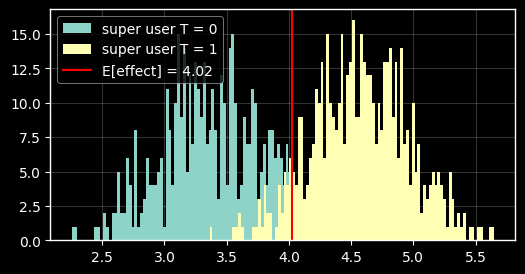

In [85]:
plt.figure(figsize=(6,3))
for super_user_grp in [0,1]:
    mc_df.query(f'super_user_grp =={super_user_grp}').effect.hist(bins=100,label=f'super user T = {super_user_grp}')
plt.grid(alpha=0.2); 

# calculate the E[effect] and variance
expected_effect = mc_df.effect.mean()
std_effect = mc_df.effect.std()
# add to the plot
plt.axvline(expected_effect,c='r',label=f'E[effect] = {round(expected_effect,2)}')
plt.legend();

expected_effect, std_effect

> Lets see if we can fix this with cupid

In [41]:
import statsmodels.formula.api as smf

def cupid_regression(df, y_col="response", t_col="T", x_col="data"):
    d = df[[y_col, t_col, x_col]].dropna()

    # Y ~ T + X includes an intercept by default
    model = smf.ols(f"{y_col} ~ {t_col} + {x_col}", data=d)
    # fit the model
    res = model.fit()
    # pull relevant information
    effect, t_stat, p_val = res.params["T"], res.tvalues["T"], res.pvalues["T"]
    return res, effect, t_stat, p_val

res, effect, t_stat, p_val = cupid_regression(df, y_col="response", t_col="T", x_col="pareto")
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1344.
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           3.37e-42
Time:                        11:49:12   Log-Likelihood:                -72.064
No. Observations:                  50   AIC:                             150.1
Df Residuals:                      47   BIC:                             155.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0275      0.317      0.087      0.9

In [45]:
def cupid_mc(df,iters=1000, data_col = 'data'):
    outs = []
    for _ in range(iters):
        # split into groups
        grouped_df = simulate_response_variable(df, data_col = data_col)
        # keep track of which group the super user ended up in (just for demonstrating the point)
        super_user_grp = grouped_df['T'].iloc[0] # its the first row
        # calculate the effect and t test stats
        res, effect, t_stat, p_val = cupid_regression(grouped_df)
        outs.append([effect, t_stat, p_val, super_user_grp])
    out_df = pd.DataFrame(outs, columns = ['effect', 't_stat', 'p_val', 'super_user_grp'])
    return out_df

n_iters = 200
cupid_mc_df = cupid_mc(df, iters=n_iters, data_col = 'pareto')
cupid_mc_df.head()

,effect,t_stat,p_val,super_user_grp
0,3.165662,2.959743,0.004811,1
1,3.424379,3.374473,0.001490,0
2,4.135046,4.404595,0.000061,1
3,2.763383,2.834771,0.006740,0
4,4.893570,5.034501,0.000007,1


> With a toy example, we completely eliminate the issue. We are "right" 100% of the time and now this sample size is more than adequate

In [46]:
# correct True Positives -- Power = 1-B (where B is FN)
power = (cupid_mc_df.p_val < 0.05).sum() / n_iters
# calculate the E[effect] and variance
expected_effect = cupid_mc_df.effect.mean()
std_effect = cupid_mc_df.effect.std()
expected_effect, std_effect, power

(3.907701712160018, 0.9574889744942492, 0.985)

# Old: Single super user, otherwise normally distributed
Lets make a toy dataset where we would get exchangeability issues.  Lets just say they are all centered around a mean and then one of them is 3x the others.

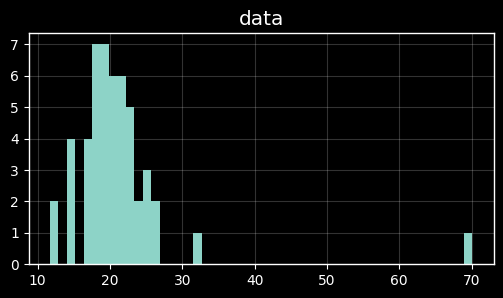

In [5]:
data = np.random.normal(20,4,50)
data[0] *= 3
df = pd.DataFrame(data, columns=['data'])
df.hist(bins=50, figsize=(6,3)); plt.grid(alpha=0.2);

Lets say that `y = b0 + b1 * T` where b0 is the mean of response variable in the control group and b1 is the treatment effect - lets set that to 4.

In [47]:
def simulate_response_variable(df, data_col ='data', effect_mu=4, effect_std=0.5):
    '''Single run of the MC'''
    n = df.shape[0]
    mask = np.random.choice(n, size=n//2, replace=False) # includes 0
    df['T'] = df.index.isin(mask).astype(int)
    effects = np.random.normal(loc=effect_mu, scale=effect_std, size=len(df))
    eps = np.random.normal(loc=0, scale=1, size=len(df))
    df['response'] = df[data_col] + effects * df['T'] + eps
    return df

df = simulate_response_variable(df, data_col = 'data')
df.head()

,data,pareto,T,response
49,14.455313,45.81,1,19.639418
37,15.630378,30.99,1,21.362131
9,15.987628,27.68,1,19.446337
22,16.934503,20.76,1,20.602208
1,17.110321,19.71,1,20.832663


In [48]:
from scipy import stats
import statsmodels.api as sm

def calculate_stats(df):
    # split into treated and 
    treated = df.loc[df['T'] == 1,'response']
    control = df.loc[df['T'] == 0,'response']
    effect = treated.mean() - control.mean()

    t_stat, p_val = stats.ttest_ind(treated, control, equal_var=False)
    return effect, t_stat, p_val

calculate_stats(df)

(3.6609851286670434, 5.810681843371527, 6.518622646214667e-07)

In [49]:
def run_mc(df, iters=1000, data_col = 'data'):
    outs = []
    for _ in range(iters):
        # split into groups
        grouped_df = simulate_response_variable(df, data_col = data_col)
        # keep track of which group the super user ended up in (just for demonstrating the point)
        super_user_grp = grouped_df['T'].iloc[0] # its the first row
        # calculate the effect and t test stats
        effect, t_stat, p_val = calculate_stats(grouped_df)
        outs.append([effect, t_stat, p_val, super_user_grp])
    out_df = pd.DataFrame(outs, columns = ['effect', 't_stat', 'p_val', 'super_user_grp'])
    return out_df
n_iters = 1000
mc_df = run_mc(df, iters=n_iters, data_col = 'data')
mc_df.head()

,effect,t_stat,p_val,super_user_grp
0,2.533619,3.940816,2.671813e-04,1
1,3.641093,5.383971,2.155533e-06,1
2,4.050787,5.529882,1.395350e-06,0
3,3.703894,5.878557,4.209751e-07,1
4,3.629207,5.412939,1.951678e-06,1


> So we're only "right" in our decision 27.5% of the time and it's because the variance is so high.  So our type 2 error rate is super high (we are constantly rejecting the null eventhough there is a huge effect)

In [50]:
power = (mc_df.p_val < 0.05).sum() / n_iters
power

1.0

(4.078941741444466, 2.1321226531886612)

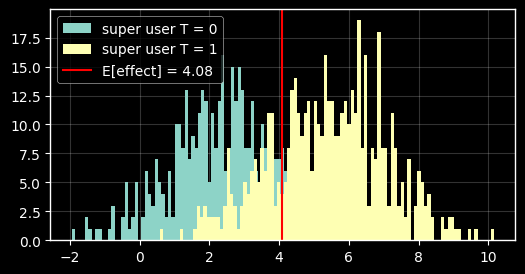

In [39]:
plt.figure(figsize=(6,3))
for super_user_grp in [0,1]:
    mc_df.query(f'super_user_grp =={super_user_grp}').effect.hist(bins=100,label=f'super user T = {super_user_grp}')
plt.grid(alpha=0.2); 

# calculate the E[effect] and variance
expected_effect = mc_df.effect.mean()
std_effect = mc_df.effect.std()
# add to the plot
plt.axvline(expected_effect,c='r',label=f'E[effect] = {round(expected_effect,2)}')
plt.legend();

expected_effect, std_effect

> Lets see if we can fix this with cupid

In [41]:
import statsmodels.formula.api as smf

def cupid_regression(df, y_col="response", t_col="T", x_col="data"):
    d = df[[y_col, t_col, x_col]].dropna()

    # Y ~ T + X includes an intercept by default
    model = smf.ols(f"{y_col} ~ {t_col} + {x_col}", data=d)
    # fit the model
    res = model.fit()
    # pull relevant information
    effect, t_stat, p_val = res.params["T"], res.tvalues["T"], res.pvalues["T"]
    return res, effect, t_stat, p_val

res, effect, t_stat, p_val = cupid_regression(df, y_col="response", t_col="T", x_col="pareto")
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1344.
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           3.37e-42
Time:                        11:49:12   Log-Likelihood:                -72.064
No. Observations:                  50   AIC:                             150.1
Df Residuals:                      47   BIC:                             155.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0275      0.317      0.087      0.9

In [45]:
def cupid_mc(df,iters=1000, data_col = 'data'):
    outs = []
    for _ in range(iters):
        # split into groups
        grouped_df = simulate_response_variable(df, data_col = data_col)
        # keep track of which group the super user ended up in (just for demonstrating the point)
        super_user_grp = grouped_df['T'].iloc[0] # its the first row
        # calculate the effect and t test stats
        res, effect, t_stat, p_val = cupid_regression(grouped_df)
        outs.append([effect, t_stat, p_val, super_user_grp])
    out_df = pd.DataFrame(outs, columns = ['effect', 't_stat', 'p_val', 'super_user_grp'])
    return out_df

n_iters = 200
cupid_mc_df = cupid_mc(df, iters=n_iters, data_col = 'pareto')
cupid_mc_df.head()

,effect,t_stat,p_val,super_user_grp
0,3.165662,2.959743,0.004811,1
1,3.424379,3.374473,0.001490,0
2,4.135046,4.404595,0.000061,1
3,2.763383,2.834771,0.006740,0
4,4.893570,5.034501,0.000007,1


> With a toy example, we completely eliminate the issue. We are "right" 100% of the time and now this sample size is more than adequate

In [46]:
power = (cupid_mc_df.p_val < 0.05).sum() / n_iters
# calculate the E[effect] and variance
expected_effect = cupid_mc_df.effect.mean()
std_effect = cupid_mc_df.effect.std()
expected_effect, std_effect, power

(3.907701712160018, 0.9574889744942492, 0.985)